# Control-Z Gate Sequence.

## Introduction

In this tutorial we show how to prepare the pulse sequence that generates a *Controlled - Z* gate. We will prepare our state with atoms in any of the "digital" states that we shall call $|g\rangle$ and $|h \rangle$ ( for "ground" and "hyperfine", respectively). Then we will use the *Rydberg blockade* effect to create the logic gate. The levels that each atom can take are the following: 

<center>
    <img src="files/three_states.png" alt="Three-state Configuration" width="120">
</center>

We will be using *NumPy* and *Matplotlib* for calculations and plots. Many additional details about the CZ gate construction can be found in [1111.6083v2](https://arxiv.org/abs/1111.6083)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip
from itertools import product

We import the following Classes from Pulser:

In [2]:
from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2
from pulser.simulation import Simulation
from pulser.waveforms import BlackmanWaveform,ConstantWaveform

## 1. Loading the Register on a Pasqal Device

Defining an atom register can simply be done by choosing one of the predetermined shapes included in the `Register`class. We can also construct a dictionary with specific labels for each atom. The atoms must lie inside the *Rydberg blockade radius* $R_b$, which we will characterize by 

$$\hbar \Omega^{\text{Max}}_{\text{Rabi}} \sim U_{ij} = \frac{C_6}{R_{b}^6},$$

where the coefficient $C_6$ determines the strength of the interaction ($C_6/\hbar \approx 5008$ GHz.$\mu m^6$). We can obtain the corresponding Rydberg blockade radius from a given $\Omega_{\text{Rabi}}^{\text{max}}$ using the `rydberg_blockade_radius()` method from `Chadoq2`. For the pulses in this tutorial, $\Omega^{\text{Max}}_{\text{Rabi}}$ is below $2\pi \times 10$ Mhz so:

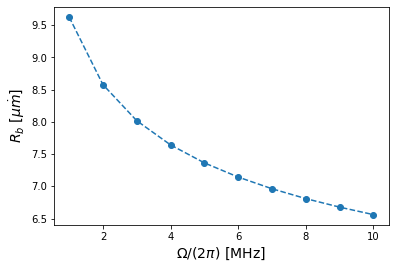

In [3]:
Rabi = np.linspace(1, 10, 10)
R_blockade = [Chadoq2.rydberg_blockade_radius(2.*np.pi*rabi) for rabi in Rabi]

plt.figure()
plt.plot(Rabi, R_blockade,'--o')
plt.xlabel(r"$\Omega/(2\pi)$ [MHz]", fontsize=14)
plt.ylabel(r"$R_b$ [$\mu\.m$]", fontsize=14)
plt.show()

Thus, we place our atoms at relative distances below $5$ µm, therefore ensuring we are inside the Rydberg blockade volume.

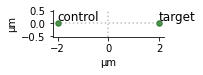

In [4]:
# Atom Register and Device
q_dict = {"control":np.array([-2,0.]),
          "target": np.array([2,0.]),
          }
reg = Register(q_dict)
reg.draw()

## 2. State Preparation

The first part of our sequence will correspond to preparing the different states on which the CZ gate will act. For this, we define the following `Pulse` instances that correspond to $\pi$ and $2\pi$ pulses (notice that the area can be easily fixed using the predefined `BlackmanWaveform`):

Let us construct a function that takes the label string (or "id") of a state and turns it into a ket state. This ket can be in any of the "digital" (ground-hyperfine levels), "ground-rydberg" or "all" levels. We also include a three-atom system case, which will be useful in the CCZ gate in the last section.

In [5]:
def build_state_from_id(s_id, basis_name):
    if len(s_id) not in {2,3}:
        raise ValueError("Not a valid state ID string")
        
    ids = {'digital': 'gh', 'ground-rydberg': 'rg', 'all': 'rgh'}
    if basis_name not in ids:
        raise ValueError('Not a valid basis')
        
    pool = {''.join(x) for x in product(ids[basis_name], repeat=len(s_id))}
    if s_id not in pool:
        raise ValueError('Not a valid state id for the given basis.')

    ket = {op: qutip.basis(len(ids[basis_name]), i) 
           for i, op in enumerate(ids[basis_name])}
    if len(s_id) == 3:
        #Recall that s_id = 'C1'+'C2'+'T' while in the register reg_id = 'C1'+'T'+'C2'.
        reg_id = s_id[0]+s_id[2]+s_id[1] 
        return qutip.tensor([ket[x] for x in reg_id])
    else:
        return qutip.tensor([ket[x] for x in s_id])

We try this out:

In [6]:
build_state_from_id('hg','digital')

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]]

Let's now write the state preparation sequence. We will also create the prepared state to be able to calculate its overlap during the simulation. First, let us define a π-pulse along the Y axis that will excite the atoms to the hyperfine state if requested:

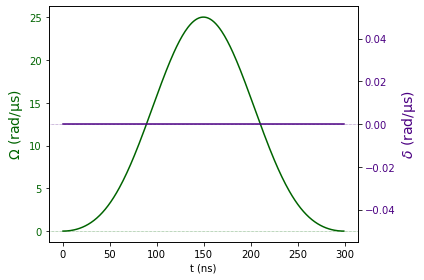

In [7]:
duration = 300 
pi_Y = Pulse.ConstantDetuning(BlackmanWaveform(duration, np.pi), 0., -np.pi/2)
pi_Y.draw()

The sequence preparation itself acts with the Raman channel if the desired initial state has atoms in the hyperfine level. We have also expanded it for the case of a CCZ in order to use it below:

In [8]:
def preparation_sequence(state_id, reg):
    global seq
    
    if not set(state_id) <= {'g','h'} or len(state_id) != len(reg.qubits):
        raise ValueError('Not a valid state ID')

    if len(reg.qubits) == 2:
        seq_dict = {'1':'target', '0':'control'}
    elif len(reg.qubits) == 3:
        seq_dict = {'2':'target', '1':'control2', '0':'control1'}

    seq = Sequence(reg, Chadoq2)
    if set(state_id) == {'g'}:
        basis = 'ground-rydberg'
        print(f'Warning: {state_id} state does not require a preparation sequence.')
    else:
        basis = 'all'
        for k in range(len(reg.qubits)):
            if state_id[k] == 'h':
                if 'raman' not in seq.declared_channels:
                    seq.declare_channel('raman','raman_local', seq_dict[str(k)])
                else:
                    seq.target(seq_dict[str(k)],'raman')
                seq.add(pi_Y,'raman')

    prep_state = build_state_from_id(state_id, basis)  # Raises error if not a valid `state_id` for the register
    
    return prep_state

Let's test this sequence. Notice that the state "gg" (both atoms in the ground state) is automatically fed to the Register so a pulse sequence is not needed to prepare it.

In [ ]:
# Define sequence and Set channels
prep_state = preparation_sequence('hh', reg)
seq.draw()

## 3. Constructing the Gate Sequence

We apply the common $\pi-2\pi-\pi$ sequence for the CZ gate 

In [ ]:
pi_pulse = Pulse.ConstantDetuning(BlackmanWaveform(duration, np.pi), 0., 0)
twopi_pulse = Pulse.ConstantDetuning(BlackmanWaveform(duration, 2*np.pi), 0., 0)

In [ ]:
def CZ_sequence(initial_id):
    
    # Prepare State
    prep_state = preparation_sequence(initial_id, reg) 
    prep_time = max((seq._last(ch).tf for ch in seq.declared_channels), default=0)
    
    # Declare Rydberg channel
    seq.declare_channel('ryd_control', 'rydberg_local', 'control')
    seq.declare_channel('ryd_target', 'rydberg_local2', 'target')
    
    # Write CZ sequence:
    seq.add(pi_pulse, 'ryd_control', 'wait-for-all')  # Wait for state preparation to finish.
    seq.align('ryd_control', 'ryd_target')  # Sets starting time of target channel equal to control channel
    seq.add(twopi_pulse, 'ryd_target')
    seq.align('ryd_control', 'ryd_target')
    seq.add(pi_pulse, 'ryd_control') 
    
    return prep_state, prep_time

In [ ]:
prep_state, prep_time = CZ_sequence('gh') # constructs seq, prep_state and prep_time
seq.draw()
print(f'Prepared state: {prep_state}')
print(f'Preparation time: {prep_time}ns')

## 4. Simulating the CZ sequence

In [ ]:
CZ = {}
for state_id in {'gg','hg','gh','hh'}:
    # Get CZ sequence
    prep_state, prep_time = CZ_sequence(state_id) # constructs seq, prep_state and prep_time
    
    # Construct Simulation instance
    simul = Simulation(seq)
    res = simul.run()
    
    data=[st.overlap(prep_state) for st in res.states]
    
    final_st = res.states[-1]
    CZ[state_id] = final_st.overlap(prep_state)
    
    plt.figure()
    plt.plot(np.real(data))
    plt.xlabel(r"Time [ns]")
    plt.ylabel(fr'$ \langle\,{state_id} |\, \psi(t)\rangle$')
    plt.axvspan(0, prep_time, alpha=0.06, color='royalblue')
    plt.title(fr"Action of gate on state $|${state_id}$\rangle$")

In [ ]:
CZ

##  5. CCZ Gate

The same principle can be applied for composite gates. As an application, let us construct the *CCZ* gate, which determines the phase depending on the level of *two* control atoms. We begin by reconstructing the Register:

In [ ]:
# Atom Register and Device
q_dict = {"control1":np.array([-2.0, 0.]),
              "target": np.array([0., 2*np.sqrt(3.001)]),
              "control2": np.array([2.0, 0.])}
reg = Register(q_dict)
reg.draw()

In [ ]:
preparation_sequence('hhh', reg)
seq.draw()

In [ ]:
def CCZ_sequence(initial_id):
    global prep_time
    # Prepare State
    prep_state = preparation_sequence(initial_id, reg)
    prep_time = max((seq._last(ch).tf for ch in seq.declared_channels), default=0)
    
    # Declare Rydberg channel
    seq.declare_channel('rydA', 'rydberg_local', 'control1')
    seq.declare_channel('rydB', 'rydberg_local2', 'control2')
    
    # Write CZ sequence:
    seq.add(pi_pulse, 'rydA', 'wait-for-all')  # Wait for state preparation to finish.
    seq.align('rydA','rydB')
    seq.add(pi_pulse, 'rydB')
    seq.target('target','rydA')
    seq.align('rydA','rydB')
    seq.add(twopi_pulse, 'rydA')
    seq.align('rydA','rydB')
    seq.add(pi_pulse, 'rydB')
    seq.target('control1','rydA')
    seq.align('rydA','rydB')
    
    seq.add(pi_pulse,'rydA')
    
    return prep_state, prep_time

In [ ]:
CCZ_sequence('hhh')
seq.draw()

In [ ]:
CCZ = {}
for state_id in {''.join(x) for x in product('gh', repeat=3)}:
    # Get CZ sequence
    prep_state, prep_time = CCZ_sequence(state_id)
    
    # Construct Simulation instance
    simul = Simulation(seq)
    
    res = simul.run()
    
    data=[st.overlap(prep_state) for st in res.states]
    final_st = res.states[-1]
    CCZ[state_id] = final_st.overlap(prep_state)
    
    #plt.plot(np.imag(data))
    plt.figure()
    plt.plot(np.real(data))
    plt.xlabel(r"Time [ns]")
    plt.ylabel(fr'$ \langle\,{state_id} | \psi(t)\rangle$')
    plt.axvspan(0, prep_time, alpha=0.06, color='royalblue')
    plt.title(fr"Action of gate on state $|${state_id}$\rangle$")

In [ ]:
CCZ

Our results are as expected: only the $|hhh\rangle$ state (which corresponds to a $111$ digital state) gets its phase flipped in sign